# Test Predictor

In [118]:
import os

from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import dataset
from Prediction import kalman_predict
from Prediction import seq2seq_predict
import imp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
from Prediction import dataset
from Prediction import seq2seq_predict as lstm
from Prediction import train_eval
import numpy as np
import pandas as pd
import pickle
import imp
import json

In [38]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(lstm)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
#imp.reload(detector)
imp.reload(dataset)

<module 'Prediction.dataset' from '/app/Pogona_realtime/Arena/Prediction/dataset.py'>

In [2]:
det = detector.Detector_v4()

Detector initiated successfully


NameError: name 'det' is not defined

## Load Data

In [39]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

47 trials loaded


(-507.7655470895063,
 2273.864490013767,
 -395.23839888336073,
 3862.7752047072668)

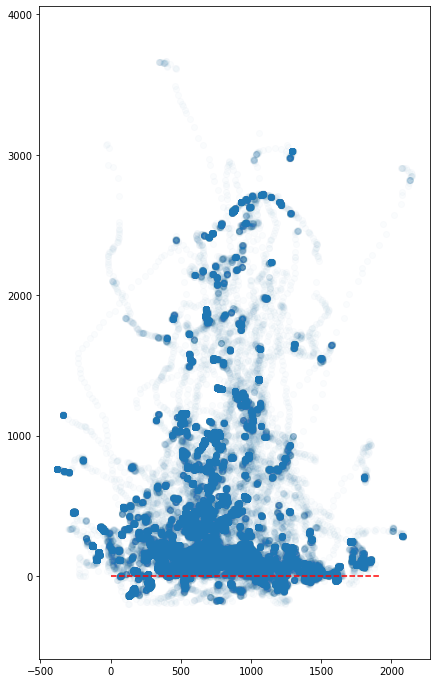

In [40]:
plt.figure(figsize=(7,12))
plt.scatter(all_df.x2,all_df.y2,alpha=0.02)
plt.plot(np.linspace(0,1920,num=10),np.zeros(10),color='r',linestyle='--')
plt.axis('equal')

In [43]:
feeding_mask = all_df.index.str.contains('feeding')

In [44]:
all_df[feeding_mask].shape

(58009, 15)

In [74]:
feeding_df = all_df[feeding_mask]

## Kalman Predictor

In [20]:
imp.reload(kalman_predict)
kalman_predictor = kalman_predict.KalmanPredictor(forecast_horizon=20, num_derivatives=1)
p = predictor.HitPredictor(kalman_predictor, detector=det, history_size=5288)

In [11]:
vid_path = "../../Pogona_Pursuit/Arena/experiments/fast_cockroach_line_20200730T131606/trial1/videos/20200730-131607/19506468.avi"
out_path = "../labelled/test_kalman_predictor_acc.mp4"

p.reset(history_size=5288)
visualize.process_video(vid_path, out_path, [visualize.predictor_visualizer(p)])

[[1.  1.  0.5 0.  0.  0. ]
 [0.  1.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.5]
 [0.  0.  0.  0.  1.  1. ]
 [0.  0.  0.  0.  0.  1. ]]
[[1.  1.  0.5 0.  0.  0. ]
 [0.  1.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.5]
 [0.  0.  0.  0.  1.  1. ]
 [0.  0.  0.  0.  0.  1. ]]



# Train Trajectory Predictor

In [45]:
def plot_train_results(results_list, title):
    fig, axs = plt.subplots(3, figsize=(10,20))
    fig.suptitle(title)

    axs[0].set_ylabel("ADE")
    axs[1].set_ylabel("FDE")
    axs[2].set_ylabel("loss")
    
    for (losses, ADEs, FDEs, name) in results_list:
        axs[0].plot(list(ADEs.values()), label=name)
        axs[0].legend()
        axs[1].plot(list(FDEs.values()), label=name)
        axs[1].legend()
        axs[2].plot(losses, label=name)
        axs[2].legend()        

In [6]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(lstm)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
#imp.reload(detector)
imp.reload(dataset)

## Single training session

In [63]:
all_trials = list(all_df.index.unique())
all_trials = list(filter(lambda trial: not all(all_df.loc[trial].x2.isna()),all_trials))

In [75]:
all_trials = list(feeding_df.index.unique())
all_trials = list(filter(lambda trial: not all(feeding_df.loc[trial].x2.isna()),all_trials))

In [76]:
train, val, test = train_eval.create_train_val_test_splits(all_trials, [0.8, 0.2, 0])

In [77]:
train, val, test

(['feeding_4_screen_20200830-130446_None',
  'feeding_4_20200830-125531_None',
  'feeding_4_20200830-121143_None',
  'feeding_4_20200830-122515_None',
  'feeding_20200830-120813_None',
  'feeding_20200830-115520_None'],
 ['feeding_4_20200830-125905_None', 'feeding_5_20200830-131348_None'],
 [])

In [85]:
results=[]
input_labels = ['x1', 'y1', 'x2', 'y2']

output_labels = ['x1', 'y1', 'x2', 'y2']
input_dim = len(input_labels)
output_dim = len(output_labels)

inp_seq_len = 20
out_seq_len = 20
embedding_size = 16
hidden_size = 64
batch_size = 128
rnn_layers = 1

In [67]:
# all_df
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(
    all_df, train, val, test, input_labels, output_labels, inp_seq_len, 
    out_seq_len, batch_size=batch_size, std_threshold=5, keep_lowvar_prob=0.2)

In [82]:
# feeding_df
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(
    feeding_df, train, val, test, input_labels, output_labels, inp_seq_len, 
    out_seq_len, batch_size=batch_size, std_threshold=2, keep_lowvar_prob=0.2)

In [83]:
len(train_dl) * batch_size

32768

## All models

In [92]:
net = lstm.LSTMdense(out_seq_len, hidden_size=hidden_size, 
                     embedding_size=embedding_size, LSTM_layers=rnn_layers, dropout=0.4)

In [86]:
net = lstm.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers,
                     tie_enc_dec=True, dropout=0.4)

In [338]:
net = lstm.GRUPositionEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, embedding_size=embedding_size,
                             GRU_layers=rnn_layers, dropout=0.4)

In [52]:
net = lstm.VelLinear(input_size=input_dim, output_size=output_dim, input_seq_size=inp_seq_len, output_seq_size=out_seq_len, hidden_size=hidden_size, dropout=0.4)

In [93]:
model_type = 'lstmDense'
model_name=f"model_{inp_seq_len}_{out_seq_len}_h{hidden_size}_b{batch_size}_l{rnn_layers}_{model_type}_feeding"
best_epoch, best_ADE, losses, ADEs, FDEs = train_eval.train_trajectory_model(
    net, train_dl, val_dl, 100, 'Prediction/traj_models/', clip_grad_norm=None,
    eval_freq=5, epoch_print_freq=5, model_name=model_name, save_each_eval_model=False)

results.append((losses, ADEs, FDEs, f"{model_type} h{hidden_size}"))

Epoch: 1, avg loss: 38.819, epoch time: 1.478
### Eval epoch: 1, Test set mean ADE: 32.405, mean FDE: 55.868
Epoch: 6, avg loss: 36.031, epoch time: 1.460
### Eval epoch: 6, Test set mean ADE: 31.196, mean FDE: 54.747
Epoch: 11, avg loss: 35.226, epoch time: 1.461
### Eval epoch: 11, Test set mean ADE: 30.900, mean FDE: 54.227
Epoch: 16, avg loss: 34.959, epoch time: 1.449
### Eval epoch: 16, Test set mean ADE: 31.388, mean FDE: 54.946
Epoch: 21, avg loss: 34.714, epoch time: 1.501
### Eval epoch: 21, Test set mean ADE: 31.292, mean FDE: 55.261
Epoch: 26, avg loss: 34.533, epoch time: 1.457
### Eval epoch: 26, Test set mean ADE: 31.424, mean FDE: 55.297
Epoch: 31, avg loss: 34.468, epoch time: 1.438
### Eval epoch: 31, Test set mean ADE: 31.031, mean FDE: 54.527
Epoch: 36, avg loss: 34.079, epoch time: 1.447
### Eval epoch: 36, Test set mean ADE: 31.092, mean FDE: 54.380
Epoch: 41, avg loss: 34.785, epoch time: 1.491
### Eval epoch: 41, Test set mean ADE: 31.204, mean FDE: 54.993
Epoch

KeyboardInterrupt: 

## Test RED (lstm+dense) Predictor

In [94]:
val

['feeding_4_20200830-125905_None', 'feeding_5_20200830-131348_None']

In [115]:
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

In [113]:
model_path = 'Prediction/traj_models/model_20_20_h64_b128_l1_lstmDense_feeding_51_best.pth'

red_predictor = seq2seq_predict.Seq2SeqPredictor(net, model_path, 20, 20)
red_hitp = predictor.HitPredictor(red_predictor, det, history_size=5288)

In [ ]:
with open('../../Pogona_Pursuit/Arena/output/feeding4_20200902-140800/rt_data/vid_stats.json','r') as f:
    vid_weird = json.load(f)

In [121]:
trial = val[0]
trial_path = os.path.join(dataset.OUTPUT_ROOT, '_'.join(trial.split('_')[:-1]))
#vid_path,_ = dataset.get_trial_path(os.path.join(dataset.EXPERIMENTS_ROOT,trial[0]),1)
vid_path = os.path.join(trial_path, '19506468.avi')
json_path = os.path.join(trial_path,'rt_data/vid_stats.json')

with open(json_path,'r') as f:
    vid_stats = json.load(f)

homography = np.array(vid_stats['homography'])
    
bboxes = all_df.loc[trial][['x1','y1','x2','y2']].values
out_name = "red_feeding_h64"
out_path = f"../labelled/{out_name}.mp4"

red_hitp.reset(history_size=5288)
correction_fn = visualize.get_correction_fn(homography,1920)

In [124]:
visualize.process_video(vid_path, 
                        out_path,
                        [visualize.offline_predictor_visualizer(red_hitp,bboxes)],
                       correction_fn = correction_fn,
                       resize_to_width=540)

In [459]:
model_path = 'Prediction/traj_models/model_20_20_h64_b64_l1_VelLinear_56_best.pth'
model = lstm.VelLinear(input_size=input_dim, output_size=output_dim, input_seq_size=inp_seq_len, output_seq_size=out_seq_len, hidden_size=hidden_size, dropout=0.4)
lin_predictor = LSTM_predict.Seq2SeqPredictor(model, model_path, inp_seq_len, out_seq_len)

In [34]:
model_path = 'Prediction/traj_models/model_20_20_h64_b64_l1_EncDec_6_best.pth'
model = lstm.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers)
#model = lstm.GRUPositionEncDec(output_seq_size=out_seq_len, hidden_size=32, embedding_size=32,
#                             GRU_layers=1, dropout=0.4)
gru_predictor = seq2seq_predict.Seq2SeqPredictor(model, model_path, inp_seq_len, out_seq_len)
hit_predictor = predictor.HitPredictor(gru_predictor, det, history_size=5288, prediction_y_threshold=900)

Detector initiated successfully


In [349]:
trial = val[1]
vid_path,_ = dataset.get_trial_path(os.path.join(EXP_BASE,trial[0]),1)
bboxes = all_df.loc[trial][['x','y','w','h']].values
out_path = "../labelled/test_gru9_pos32.mp4"

hit_predictor.reset(history_size=5288)
visualize.process_video(vid_path, out_path, [visualize.offline_predictor_visualizer(hit_predictor, bboxes)])

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


### Evaluate trajectory predictor

In [50]:
kalman_predictor = kalman_predict.KalmanPredictor(forecast_horizon=20, num_derivatives=1, q_var=0.3, r_var=500.0)

In [ ]:
bboxes = all_df.loc[val[1]][['x1','y1','x2','y2']].values
train_eval.eval_trajectory_predictor(red_predictor, bboxes)

- gru = 4.78/8.46 (3.8ms)
- red = 4.88/8.62 (0.6ms)
- vel_linear = 4.91/8.72 (0.2ms)
- kalman = 6.8852/13.116 (0.09ms)

## Hyper-parameter search (input and output sequence lengths)

In [222]:
inp_lens = range(12, 49, 8)
out_lens = inp_lens

ADEs = train_eval.grid_input_output(lstm.LSTMdense, all_df, inp_lens, out_lens, inp_labels, out_labels, 'Prediction/traj_models/RED/', 401)

Training with input_seq_len=12, output_seq_len=12
epoch: 0, loss: 777.553, epoch time: 1.367
++++++++++++++++
Eval epoch: 0, Test set mean ADE 2.219
epoch: 50, loss: 337.948, epoch time: 1.450
epoch: 100, loss: 268.827, epoch time: 1.472
++++++++++++++++
Eval epoch: 100, Test set mean ADE 2.496
epoch: 150, loss: 241.172, epoch time: 1.438
epoch: 200, loss: 227.790, epoch time: 1.429
++++++++++++++++
Eval epoch: 200, Test set mean ADE 2.527
epoch: 250, loss: 219.896, epoch time: 1.480
epoch: 300, loss: 214.207, epoch time: 1.455
++++++++++++++++
Eval epoch: 300, Test set mean ADE 2.549
epoch: 350, loss: 210.148, epoch time: 1.434
epoch: 400, loss: 206.672, epoch time: 1.524
++++++++++++++++
Eval epoch: 400, Test set mean ADE 2.563
Finished training
Training with input_seq_len=12, output_seq_len=20
epoch: 0, loss: 1068.994, epoch time: 1.496
++++++++++++++++
Eval epoch: 0, Test set mean ADE 2.946
epoch: 50, loss: 444.467, epoch time: 1.441
epoch: 100, loss: 335.257, epoch time: 1.513
+++

In [ ]:
det.